In [1]:
import torch

if torch.cuda.is_available():
    print("CUDA is available. GPU is detected.")
    device = torch.device("cuda")
    x = torch.tensor([1.0, 2.0, 3.0], device=device)
    y = torch.tensor([4.0, 5.0, 6.0], device=device)
    z = x + y
    print(f"Result of tensor addition on GPU: {z}")
else:
    print("CUDA is not available. Running on CPU.")

CUDA is available. GPU is detected.
Result of tensor addition on GPU: tensor([5., 7., 9.], device='cuda:0')


In [32]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


In [8]:
data_dir = "data\\asl_alphabet_train"
categories = os.listdir(data_dir)
img_size = 64

<h1>Pre-Processing the Data<h1>

in this section we will create a trainig data model.
<li>this model will present by array of pairs.
<li>each pair will be a pixels of image array and class of this image.
<li>for example : the letter 'A' will be [pixel array of image A , the class that present A (0)]

In [4]:
def create_training_data():
    training_data = []
    for category in categories:
        path = os.path.join(data_dir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_array = cv2.resize(img_array, (img_size, img_size))
                training_data.append([resized_array, class_num])
            except Exception as e:
                pass
    return training_data

training_data = create_training_data()
print(f"Number of samples: {len(training_data)}")

Number of samples: 87000


now we make this steps : 
<li> we shuffle all the data from the traing_data
<li> we split the training data to x_train and y_train
<li> the x_train will contain the features for us it will be the pixel array of each image
<li> the y_train will contain the labels for us it will be the class that present each image (0,1,2...)
<li> than we normelize the x_train to recive values for each array in values between 0-1
<li> we transfer the y_train to categorical for the cnn model 

In [5]:
# now we shuffle and split the data
import random
random.shuffle(training_data)

x_train = []
y_train = []

for features,label in training_data: #split the training data to x_train that contain the image array , and y_train that contain the class name (index)
    x_train.append(features)
    y_train.append(label)

x_train = np.array(x_train).reshape(-1,img_size,img_size,1) / 255.0 # normalize the values in the x_train to numbers between 0-1 
y_train = to_categorical(y_train, num_classes=len(categories))


<h1>Building a CNN model

In [6]:

model = Sequential() #create the model 

#first convolutional layer:
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)))
model.add(MaxPooling2D((2, 2)))

# Second convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten and dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(len(categories), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

c:\Users\amitx\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,289,629 (12.55 MB)

 Trainable params: 3,289,629 (12.55 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# TensorFlow GPU configuration
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [8]:
model.fit(x_train, y_train, epochs=1, validation_split=0.2)

2175/2175 ━━━━━━━━━━━━━━━━━━━━ 370s 168ms/step - accuracy: 0.5301 - loss: 1.6028 - val_accuracy: 0.9199 - val_loss: 0.2308


In [9]:
model.fit(x_train, y_train, epochs=1, validation_split=0.2)

2175/2175 ━━━━━━━━━━━━━━━━━━━━ 373s 170ms/step - accuracy: 0.9515 - loss: 0.1499 - val_accuracy: 0.9702 - val_loss: 0.0961


In [10]:
model.fit(x_train, y_train, epochs=1, validation_split=0.2)

2175/2175 ━━━━━━━━━━━━━━━━━━━━ 322s 147ms/step - accuracy: 0.9788 - loss: 0.0680 - val_accuracy: 0.9881 - val_loss: 0.0392


In [11]:
model.fit(x_train, y_train, epochs=1, validation_split=0.2)

2175/2175 ━━━━━━━━━━━━━━━━━━━━ 369s 168ms/step - accuracy: 0.9863 - loss: 0.0461 - val_accuracy: 0.9833 - val_loss: 0.0566


In [12]:
model.fit(x_train, y_train, epochs=1, validation_split=0.2)

2175/2175 ━━━━━━━━━━━━━━━━━━━━ 397s 182ms/step - accuracy: 0.9895 - loss: 0.0358 - val_accuracy: 0.9857 - val_loss: 0.0423


In [13]:
model.fit(x_train, y_train, epochs=1, validation_split=0.2)

2175/2175 ━━━━━━━━━━━━━━━━━━━━ 404s 185ms/step - accuracy: 0.9908 - loss: 0.0299 - val_accuracy: 0.9864 - val_loss: 0.0472


In [14]:
model.fit(x_train, y_train, epochs=1, validation_split=0.2)

2175/2175 ━━━━━━━━━━━━━━━━━━━━ 387s 177ms/step - accuracy: 0.9923 - loss: 0.0247 - val_accuracy: 0.9896 - val_loss: 0.0420


In [15]:
model.fit(x_train, y_train, epochs=1, validation_split=0.2)

2175/2175 ━━━━━━━━━━━━━━━━━━━━ 360s 163ms/step - accuracy: 0.9940 - loss: 0.0219 - val_accuracy: 0.9926 - val_loss: 0.0278


In [16]:
model.fit(x_train, y_train, epochs=1, validation_split=0.2)

2175/2175 ━━━━━━━━━━━━━━━━━━━━ 365s 166ms/step - accuracy: 0.9953 - loss: 0.0171 - val_accuracy: 0.9887 - val_loss: 0.0359


In [17]:
model.fit(x_train, y_train, epochs=1, validation_split=0.2)

2175/2175 ━━━━━━━━━━━━━━━━━━━━ 358s 163ms/step - accuracy: 0.9920 - loss: 0.0286 - val_accuracy: 0.9962 - val_loss: 0.0137


In [1]:
test_data = create_training_data()  

X_test = []
y_test = []

for features, label in test_data:
    X_test.append(features)
    y_test.append(label)

X_test = np.array(X_test).reshape(-1, img_size, img_size, 1) / 255.0
y_test = to_categorical(y_test, num_classes=len(categories))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

NameError: name 'create_training_data' is not defined

In [74]:
# Function to create test data
def create_test_data(test_dir):
    test_data = []
    for index,img in enumerate(os.listdir(test_dir)):
        img_array = cv2.imread(os.path.join(test_dir, img), cv2.IMREAD_GRAYSCALE)
        resized_array = cv2.resize(img_array, (img_size, img_size))
        test_data.append([resized_array ,index])
    return test_data

In [75]:
from tensorflow.keras.models import load_model

test_data = create_test_data(test_dir)

X_test = []
y_test = []

# Load test data
for features, label in test_data:
    X_test.append(features)
    y_test.append(label)

X_test = np.array(X_test).reshape(-1, img_size, img_size, 1) / 255.0
y_test = to_categorical(y_test, num_classes=len(categories))
y_test_labels = np.argmax(y_test, axis=1)

# Make predictions
model = load_model(model_path)
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


In [76]:
# Compute accuracy
accuracy = accuracy_score(y_test_labels, y_pred_labels)

# Compute F1 score (macro and micro)
f1_macro = f1_score(y_test_labels, y_pred_labels, average='macro')
f1_micro = f1_score(y_test_labels, y_pred_labels, average='micro')

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

# Display metrics
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Macro): {f1_macro}")
print(f"F1 Score (Micro): {f1_micro}")

# Create a DataFrame for metrics
metrics_data = {
    'Metric': ['Accuracy', 'F1 Score (Macro)', 'F1 Score (Micro)'],
    'Score': [accuracy, f1_macro, f1_micro]
}
metrics_df = pd.DataFrame(metrics_data)

# Display the metrics table
print(metrics_df)

Accuracy: 0.21428571428571427
F1 Score (Macro): 0.20689655172413793
F1 Score (Micro): 0.21428571428571427
             Metric     Score
0          Accuracy  0.214286
1  F1 Score (Macro)  0.206897
2  F1 Score (Micro)  0.214286


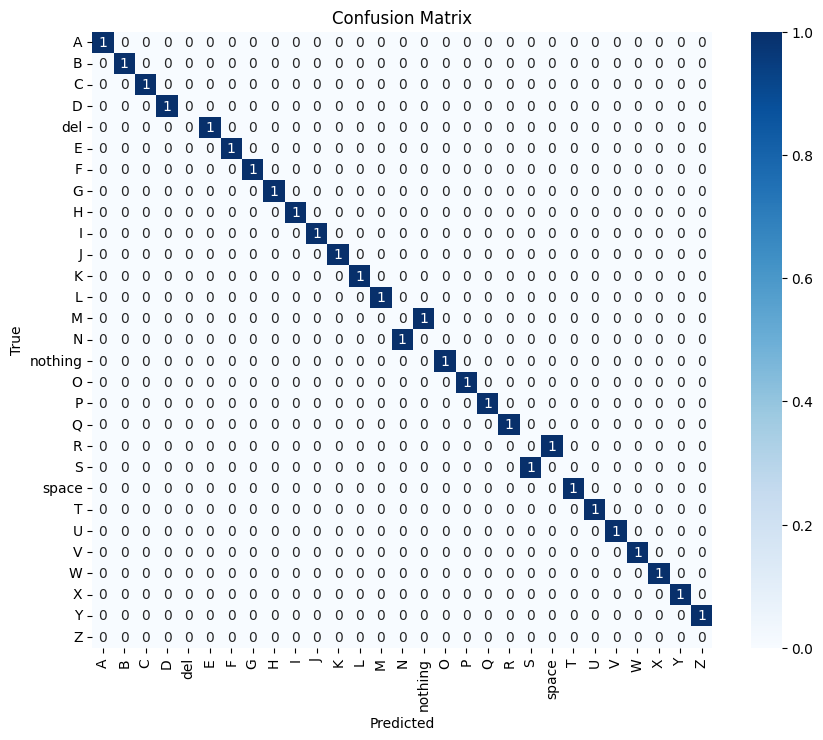

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

# Display confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

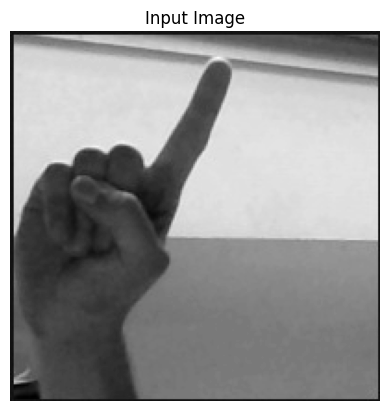

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Predicted Sign: Z


In [78]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def predict_and_display(image_path):
    # Load and preprocess the image
    img_array = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    resized_array = cv2.resize(img_array, (img_size, img_size)).reshape(-1, img_size, img_size, 1) / 255.0
    
    # Display the image
    plt.imshow(img_array, cmap='gray')
    plt.title('Input Image')
    plt.axis('off')
    plt.show()
    
    # Make prediction
    prediction = model.predict(resized_array)
    predicted_label = categories[np.argmax(prediction)]
    
    # Display prediction
    print(f"Predicted Sign: {predicted_label}")
predict_and_display('data\\asl_alphabet_test\\Z_test.jpg')